# Day 7 Linear Regression

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## 线性回归模型
——将数据拟合成一条直线。直线拟合的模型方程为 y = ax + b，其中 a 是直线斜率，b 是直线截距(略)

然而，LinearRegression 评估器能做的可远不止这些——除了简单的直线拟合，它还可以 处理多维度的线性回归模型:
<br>`y=a0 +a1x1 +a2x2 +...`
<br>虽然这类回归模型的多维特性使得它们很难可视化，但是我们可以用 NumPy 的矩阵乘法 运算符创建一些数据，从而演示这类拟合过程:

In [2]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)

rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3) # y = a0 + a1x1 + a2x2 + a3x3
y = 0.5 + np.dot(X, [1.5, -2., 1.])
model.fit(X, y)
print(model.intercept_)
print(model.coef_) # 因前面数据维度是(100,3),其中 y 变量是由 3 个随机的 x 变量线性组合而成，线性回归模型还原了方程的系数。

0.5000000000000091
[ 1.5 -2.   1. ]


/Users/har/py/virtualenv/data_analysis/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


## 基函数回归
不就**变量替换**? y = b0 + b1x + b2x^2。那么令z1 = x, z2 = x^2 。目标函数就变为 y = b0 + b1z1 + b2z2
<br>通过基函数对原始数据进行变换，从而将变量间的线性回归模型转换为非线性回归模型。
<br> 这个方法的多维模型是:
$$y = a_0 + a_1x_1 + a_2x_2 + ...$$
其中一维的输入变量 x 转换成了三维变量 x1、x2、和 x3。让 xn = fn(x)，这里的 fn() 是转换数
据的函数。
<br>假如 fn(x) = xn，那么模型就会变成多项式回归:
<br>$$y=a_0 + a_1x+a_2x^2 +a_3x^3 +...$$
需要注意的是，这个模型仍然是一个线性模型，也就是说系数 an 彼此不会相乘或相除。我 们其实是将一维的 x 投影到了高维空间，因此通过线性模型就可以拟合出 x 与 y 间更复杂 的关系。
### 1. 多项式基函数：

In [3]:
from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None]) #转换器通过指数函数，将一维数组转换成了三维数组。

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

最简洁的方式是用管道实现这些过程, 比如创建一个 7 次多 项式回归模型:

In [4]:
from sklearn.pipeline import make_pipeline

poly_model = make_pipeline(PolynomialFeatures(7),
                                        LinearRegression())

数据经过转换之后，我们就可以**用线性模型来拟合(非线性关系)** x 和 y 之间更复杂的关系了。例如，下面是一条带噪的正弦波:

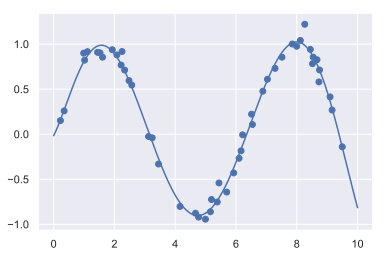

In [5]:
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)
poly_model.fit(x[:, np.newaxis], y)
xfit = np.linspace(0, 10, 1000)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)

### 2. 高斯基函数
Scikit-Learn 并没有内置这些高斯基函数，但我们可以自己写一个转换器来创建高斯基函数，(Scikit-Learn 的转换器都是用 Python 类实现的，阅读 Scikit-Learn 的源代码可能更好地理解它们的创建方式)

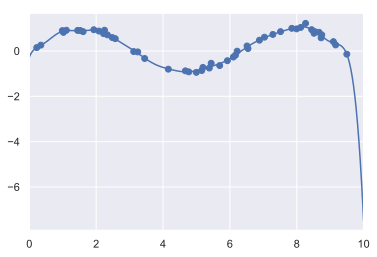

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

### 3. 正则化
虽然在线性回归模型中引入基函数会让模型变得更加灵活，但是也很容易造成过拟合, 如果选择了太多高斯基函数，那么最终的拟合结果看起来可能并不好:

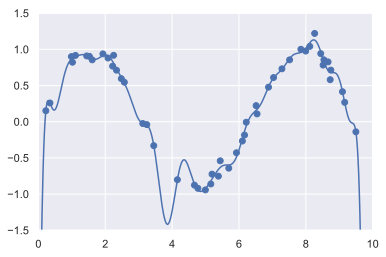

In [7]:
model = make_pipeline(GaussianFeatures(30), # 过高的高斯基函数
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

如果将高斯基函数的系数画出来，就可以看到过拟合的原因:

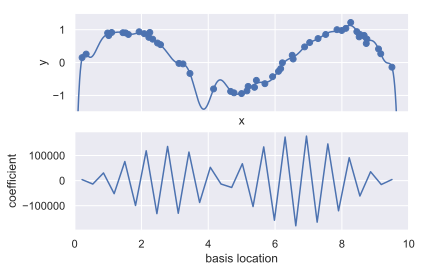

In [8]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

下面那幅图显示了每个位置上基函数的振幅, 当基函数重叠的时候，通常就表明出 现了过拟合:相邻基函数的系数相互抵消。这显然是有问题的，如果对较大的模型参数进 行惩罚(penalize)，从而抑制模型剧烈波动，应该就可以解决这个问题了。这个惩罚机制 被称为**正则化(regularization)**，有以下几种不同的表现形式：
* 岭回归(L2范数正则化): 其处理方法是**对模型系数平方和(L2 范数)**进行惩罚，内置在sklearn的Ridge评估器中
* Lasso正则化(L1范数):其处理方法是对**模型系数绝对值的和(L1 范数)**进行 惩罚, 虽然它在形式上非常接近岭回归，但是其结果与岭回归差别很大。例如，由于其几何特 性，Lasso 正则化倾向于构建稀疏模型;也就是说，它更喜欢将模型系数设置为 0。

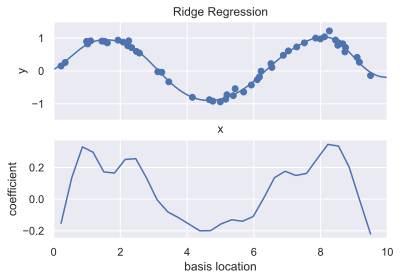

In [9]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

**参数 α(alpha) 是控制最终模型复杂度的关键**
<br>如果 α → 0，那么模型就恢复到标准线性回归结果(不惩罚); 如果 α → ∞，那么所有模型响应都会被压制。岭回归的一个重要优点是，它可以非常高效 地计算——因此相比原始的线性回归模型，几乎没有消耗更多的计算资源。

## 案例:预测自行车流量
下面来尝试预测美国西雅图弗雷蒙特桥的自行车流量，数据源自不同天气、季节和其他条 件下通过该桥的自行车统计数据。

In [10]:
import pandas as pd
import time

In [11]:
a = time.time()
counts = pd.read_csv('../datasets/FremontBridge.csv', index_col='Date', parse_dates=True)
# parse_dates=True, 带上这个parse_dates耗时立马增加100倍!! 
print(time.time() - a)
weather = pd.read_csv('../datasets/BicycleWeather.csv', index_col='DATE', parse_dates=True)

10.031051874160767


In [12]:
counts.columns = ['West', 'East']
print(counts.head())
print('-------------------------------------------')
print(weather.head())

                     West  East
Date                           
2012-10-03 00:00:00   9.0   4.0
2012-10-03 01:00:00   6.0   4.0
2012-10-03 02:00:00   1.0   1.0
2012-10-03 03:00:00   3.0   2.0
2012-10-03 04:00:00   1.0   6.0
-------------------------------------------
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-03  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-04  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-05  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   

            PRCP  SNWD  SNOW  TMAX  TMIN  AWND  WDF2  WDF5  ...   WT17  WT05  \
DATE                                                        ...                
2012-01-01     0     0     0   1

In [13]:
daily = counts.resample('d').sum()
print(daily.head())

daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns
daily.head()

              West    East
Date                      
2012-10-03  1761.0  1760.0
2012-10-04  1767.0  1708.0
2012-10-05  1590.0  1558.0
2012-10-06   926.0  1080.0
2012-10-07   951.0  1191.0


,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


然后计算每一天的自行车流量，将结果放到一个新的 DataFrame 中:

In [14]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


骑车人数在节假日也有所变化。因此，再增加一列表示当天是否为节假日:

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)
daily.head()

我们还认为白昼时间也会影响骑车人数。因此，用标准的天文计算来添加这列信息:

In [ ]:
def hours_of_daylight(date, axis=23.44, latitude=47.61): 
    """计算指定日期的白昼时间"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.


daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()

#### 未完....
详见[Linear Regression](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb)
或pdf Page 375